# integrated_gradients static

In [1]:
from typing import List, Dict, Any, Tuple, Optional, Union
from pathlib import Path
import numpy as np 
import xarray as xr 
import pandas as pd
import sys

sys.path.append("/home/tommy/neuralhydrology")
from neuralhydrology.datasetzoo import PixelDataset
from neuralhydrology.datautils.utils import load_basin_file
from neuralhydrology.datasetzoo import CamelsGB
import pickle 
import random
from tqdm import tqdm 
import matplotlib.pyplot as plt
import seaborn as sns

from scripts.read_nh_results import (
    get_test_filepath,
    get_all_station_ds,
    calculate_all_error_metrics,
    get_ensemble_path,
)

from scripts.read_model import (get_model, _load_weights)
from neuralhydrology.utils.config import Config

# Load Model, Config and Data

In [3]:
import geopandas as gpd
from scripts.geospatial import initialise_gb_spatial_plot, load_latlon_points, get_regions_data
from mpl_toolkits.axes_grid1 import make_axes_locatable

data_dir = Path("/datadrive/data")
st_data_dir = data_dir
points = load_latlon_points(st_data_dir)
static = xr.open_dataset(st_data_dir / "camels_static.nc")
static["station_id"] = static["station_id"].astype(int)

In [4]:
# run_dir = Path("/datadrive/data/runs/azure_nh_runoff_30EPOCH_0306_200242")
# run_dir = Path("/datadrive/data/runs/complexity_AZURE/hs_004_0406_152711")
run_dir = Path("/datadrive/data/runs/complexity_AZURE/hs_064_0306_205514")

# load config
cfg = Config(run_dir / "config.yml")
cfg.run_dir = run_dir

# load model
device = cfg.device
model = get_model(cfg).to(device)
_load_weights(model, cfg)

Using the model weights from /datadrive/data/runs/complexity_AZURE/hs_064_0306_205514/model_epoch030.pt


CudaLSTM(
  (embedding_net): InputLayer(
    (statics_embedding): Identity()
    (dynamics_embedding): Identity()
  )
  (lstm): LSTM(25, 64)
  (dropout): Dropout(p=0.4, inplace=False)
  (head): Regression(
    (net): Sequential(
      (0): Linear(in_features=64, out_features=1, bias=True)
    )
  )
)

In [5]:
# cfg.static_attributes

In [7]:
ds = xr.open_dataset(Path("/datadrive/data/RUNOFF/ALL_dynamic_ds.nc"))
ds["station_id"] = ds["station_id"].astype(int)

res_fp = get_test_filepath(run_dir, epoch=30)
preds = get_all_station_ds(res_fp)

100%|██████████| 669/669 [00:00<00:00, 1591.88it/s]


# load Integrated gradients

In [8]:
from scripts.integrated_gradients import create_gradient_xarray
from scripts.cell_state.timeseries_model import _round_time_to_hour
from tqdm import tqdm

In [9]:
baseline_type = "static"
target_type = "cell_state"

# gradients = xr.open_dataset(run_dir / "integrated_gradients/static2cell_state_gradients.nc")

# if "gradients" not in globals().keys():
if True:
    gradients = create_gradient_xarray(cfg, run_dir, baseline_type=baseline_type, target_type=target_type)
    gradients["station_id"] = gradients["station_id"].astype(int)

    # assign time to gradients
    if baseline_type == "dynamic":
        if not (data_dir / "gradients_time.nc").exists():
            actual_time = gradients.target_time - gradients.seq_length
            gradients = gradients.assign_coords(time=actual_time)
            for seq_ix in tqdm(np.arange(gradients["time"].shape[-1])):    
                gradients["time"].values[:, seq_ix] = _round_time_to_hour(gradients["time"].values[:, seq_ix])
        else:
            actual_time = xr.open_dataset(data_dir / "gradients_time.nc")
            gradients = gradients.assign_coords(time=actual_time.to_array().isel(variable=0))
        gradients = gradients.sortby("seq_length", ascending=False)
        
gradients

Creating Gradient Xarray: 100%|██████████| 154/154 [01:05<00:00,  2.37it/s, 21017]


<xarray.Dataset>
Dimensions:               (dimension: 64, station_id: 152, target_time: 4018)
Coordinates:
  * station_id            (station_id) int64 40020 10002 10003 ... 49001 21017
  * target_time           (target_time) datetime64[ns] 1998-01-01 ... 2008-12-31
  * dimension             (dimension) int64 0 1 2 3 4 5 6 ... 58 59 60 61 62 63
Data variables: (12/22)
    area                  (station_id, target_time, dimension) float64 0.0107...
    elev_mean             (station_id, target_time, dimension) float64 -0.142...
    dpsbar                (station_id, target_time, dimension) float64 -0.023...
    sand_perc             (station_id, target_time, dimension) float64 -0.039...
    silt_perc             (station_id, target_time, dimension) float64 0.0800...
    clay_perc             (station_id, target_time, dimension) float64 -0.45 ...
    ...                    ...
    p_seasonality         (station_id, target_time, dimension) float64 -0.235...
    frac_snow             (station_id, target_time, dimension) float64 -0.0 ....
    high_prec_freq        (station_id, target_time, dimension) float64 -0.253...
    low_prec_freq         (station_id, target_time, dimension) float64 0.0701...
    high_prec_dur         (station_id, target_time, dimension) float64 -0.020...
    low_prec_dur          (station_id, target_time, dimension) float64 -0.197...

# contribution of input features

In [11]:
mean_ = gradients.median(dim=["station_id", "target_time"])

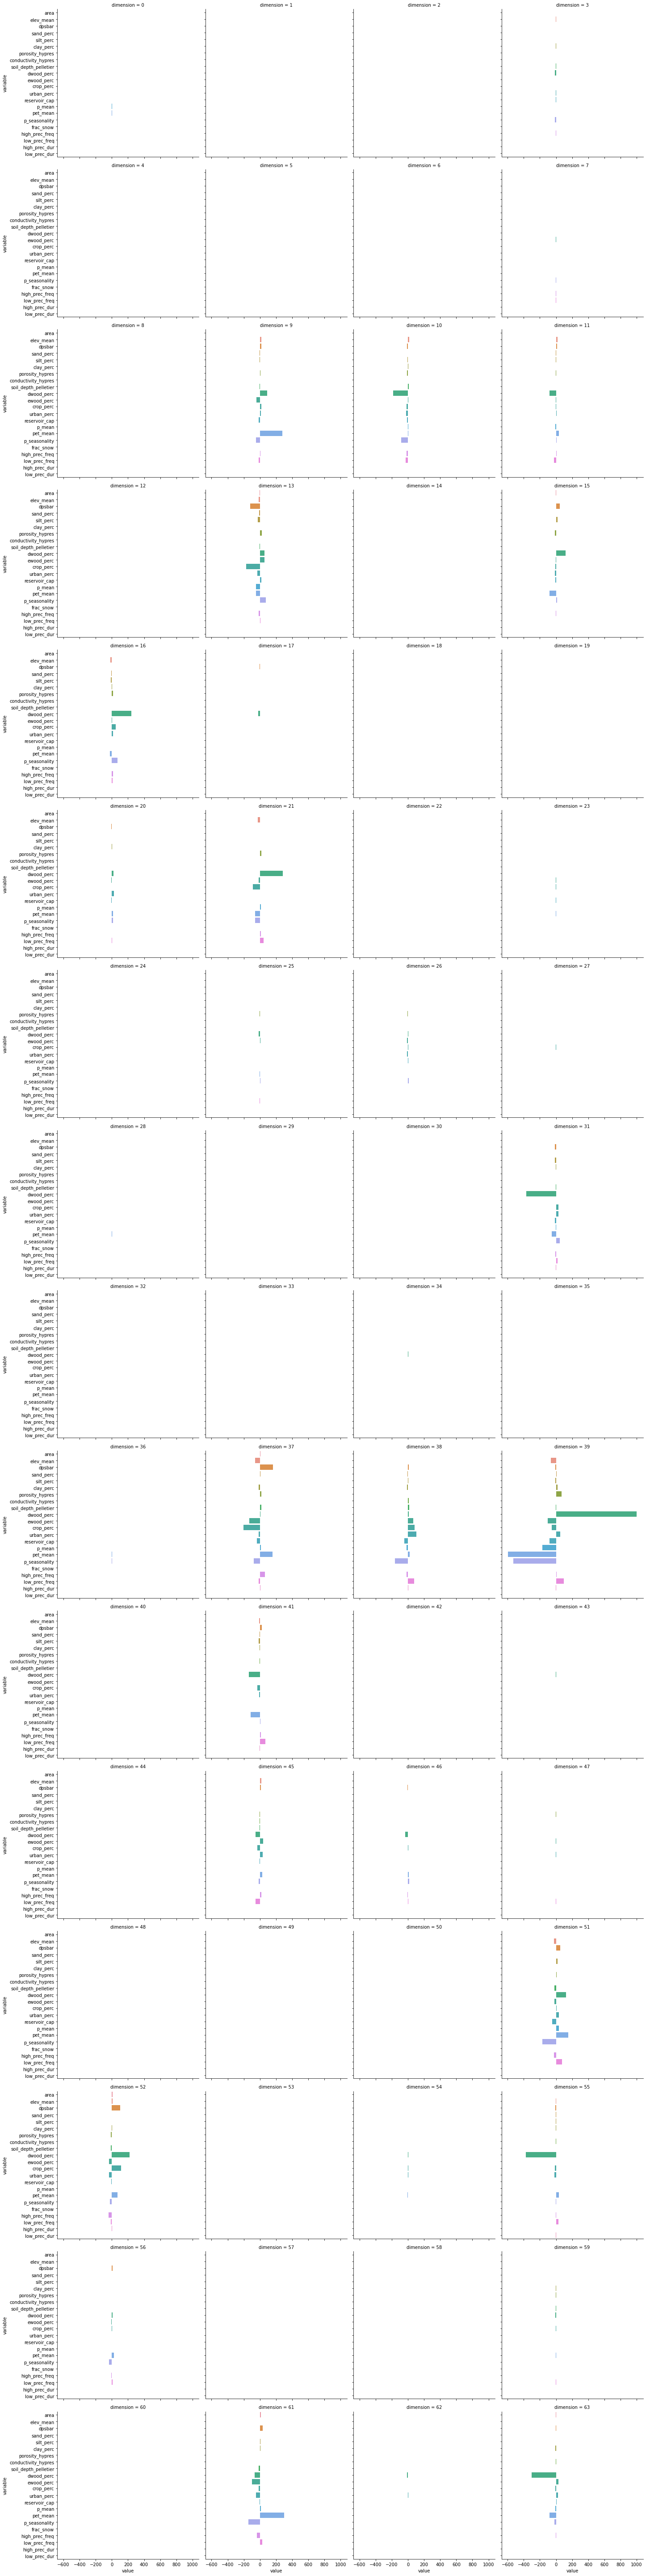

In [12]:
df = mean_.to_dataframe().unstack().reset_index().rename({0: "value", "level_0": "variable"}, axis=1)
sns.catplot(y="variable", x="value", col="dimension", kind="bar", data=df, orient="h", col_wrap=4)

# What about the cell states that we are already aware of?

In [36]:
# gradients
sids = static.sel(station_id=gradients.station_id)["frac_snow"] >= 0.05
snowsids = sids["station_id"][sids]

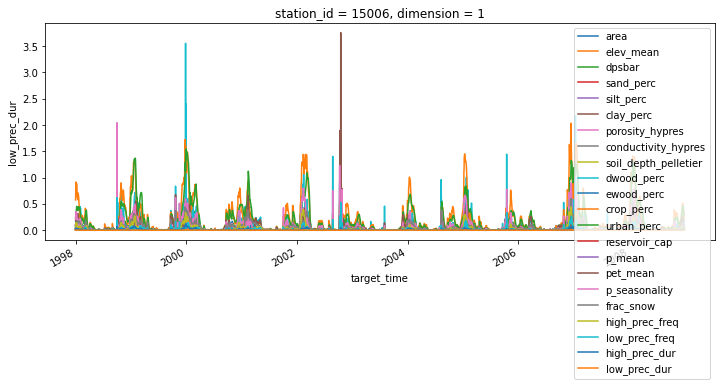

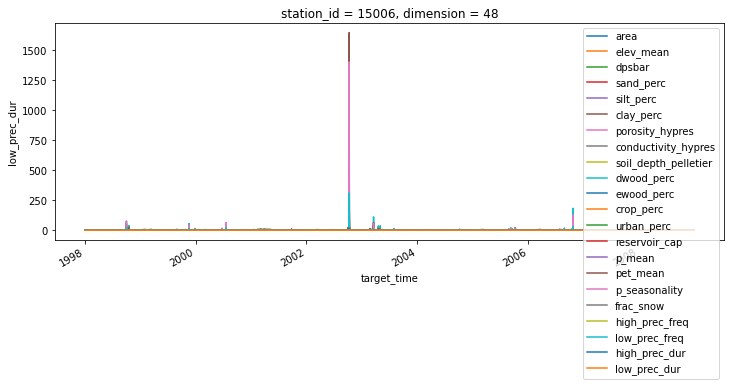

In [48]:
sid = np.random.choice(snowsids)
data = np.abs(gradients.sel(dimension=[1, 48], station_id=sid))

for dim in data.dimension.values:
    f, ax = plt.subplots(figsize=(12, 4))
    for var in data.data_vars:
        data.sel(dimension=dim)[var].plot(label=var)
        plt.legend()

In [42]:
data

<xarray.Dataset>
Dimensions:               (dimension: 2, target_time: 4018)
Coordinates:
    station_id            int64 15014
  * target_time           (target_time) datetime64[ns] 1998-01-01 ... 2008-12-31
  * dimension             (dimension) int64 1 48
Data variables: (12/22)
    area                  (target_time, dimension) float64 -0.00122 ... -0.04568
    elev_mean             (target_time, dimension) float64 0.005338 ... -0.01931
    dpsbar                (target_time, dimension) float64 -0.08557 ... -0.4889
    sand_perc             (target_time, dimension) float64 0.0 0.0 ... 0.0 0.0
    silt_perc             (target_time, dimension) float64 -0.01866 ... 0.09612
    clay_perc             (target_time, dimension) float64 -0.0005321 ... -0....
    ...                    ...
    p_seasonality         (target_time, dimension) float64 -0.03123 ... 1.303
    frac_snow             (target_time, dimension) float64 0.0 0.0 ... 0.0 0.0
    high_prec_freq        (target_time, dimension) float64 -0.02717 ... 0.5605
    low_prec_freq         (target_time, dimension) float64 -0.0146 ... 0.1106
    high_prec_dur         (target_time, dimension) float64 -0.002183 ... 0.03514
    low_prec_dur          (target_time, dimension) float64 -1.555e-06 ... -0....

# View the cell state timeseries 

In [31]:
regions_data = get_regions_data(gis_data_dir=data_dir / "RUNOFF/gis_data_Tommy", data_dir=data_dir)
regions_data.head()

,region,region_abbr
station_id,,
1001,Western Scotland,WS
2001,Western Scotland,WS
2002,Western Scotland,WS
3003,Western Scotland,WS
4001,Western Scotland,WS


In [32]:
from scripts.cell_state.extract_cell_state import get_cell_states

out_dir = run_dir / "cell_states"
if not out_dir.exists():
    out_dir.mkdir(parents=True, exist_ok=True)

if not (out_dir / "cell_states.nc").exists():
    cn = get_cell_states(cfg, run_dir)
    cn.to_netcdf(out_dir / "cell_states.nc")
else:
    cn = xr.open_dataset(out_dir / "cell_states.nc")
    

cn["station_id"] = cn["station_id"].astype(int)

_mean = cn.mean(["date", "station_id"])
_std = cn.std(["date", "station_id"])
norm_cn = (cn - _mean) / _std

In [33]:
preds["station_id"] = preds["station_id"].astype(int)
preds

<xarray.Dataset>
Dimensions:             (date: 4018, station_id: 669)
Coordinates:
  * station_id          (station_id) int64 10002 10003 1001 ... 96004 97002
  * date                (date) datetime64[ns] 1998-01-01 ... 2008-12-31
Data variables:
    discharge_spec_obs  (station_id, date) float64 2.37 2.49 2.42 ... 0.73 0.79
    discharge_spec_sim  (station_id, date) float64 1.815 2.037 ... 0.9935 1.049

In [36]:
# data

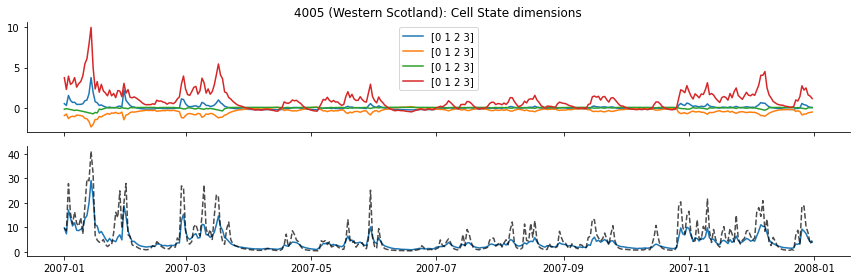

In [34]:
time = "2007"
sid = np.random.choice(cn["station_id"].values)
data = norm_cn.sel(date=time, station_id=sid)["c_n"]
p = preds.sel(date=time, station_id=sid)

f, axs = plt.subplots(2, 1, figsize=(12, 4), sharex=True)

ax = axs[0]
ax.plot(data.date, data.values, label=data.dimension.values)
ax.legend()
region = regions_data.loc[sid, "region"]
ax.set_title(f"{sid} ({region}): Cell State dimensions")

ax = axs[1]
ax.plot(p.date, p["discharge_spec_sim"], ls="-", color="C0", label="Sim")
ax.plot(p.date, p["discharge_spec_obs"], ls="--", color="k", label="Obs", alpha=0.7)

plt.tight_layout()
sns.despine()

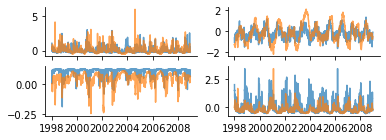

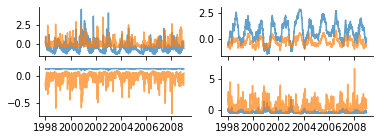

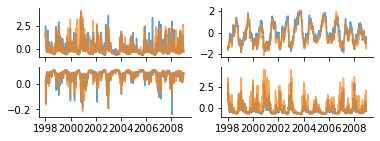

In [56]:
N = 3

for _ in np.arange(N):
    f, axs = plt.subplots(2, 2, figsize=(3*2, 1*2), sharex=True, sharey=False)
    for s_ix in np.arange(2):
        sid = np.random.choice(cn["station_id"].values)
        data = norm_cn.sel(station_id=sid)["c_n"]

        for d_ix in np.arange(4):
            ax = axs[np.unravel_index(d_ix, (2,2))]
            d = data.sel(dimension=d_ix)
            ax.plot(d.date, d.values, alpha=0.7, color=f"C{s_ix}")
            sns.despine()

# Check the linear probes

In [ ]:
TARGET = "ERA5"

In [38]:
from scripts.cell_state.utils import (
    read_basin_list, 
    get_train_test_cell_states, 
    normalize_and_convert_dimension_to_variable_for_cell_state_data, 
    create_train_test_default_dict_for_all_target_vars, 
    train_and_evaluate_models
)

ds = xr.open_dataset("/home/tommy/spatio_temporal/data/ALL_dynamic_ds.nc")

train_sids = read_basin_list(cfg.train_basin_file)
test_sids = read_basin_list(cfg.test_basin_file)
train_ds = ds.sel(time=slice(cfg.train_start_date, cfg.train_end_date), station_id=np.isin(ds.station_id, train_sids.station_id))
test_ds = ds.sel(time=slice(cfg.test_start_date, cfg.test_end_date), station_id=np.isin(ds.station_id, test_sids.station_id))

out_of_sample = not all(np.isin(test_sids, train_sids))
print(f"Out of Sample: {not all(np.isin(test_sids, train_sids))}")

Out of Sample: False


In [39]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

train_cn, test_cn = get_train_test_cell_states(run_dir, cfg)

Extracting cell state for basin:   0%|          | 0/669 [00:00<?, ?it/s]

Using the model weights from /datadrive/data/runs/complexity_AZURE/hs_004_0406_152711/model_epoch030.pt


Extracting cell state for basin:   0%|          | 0/669 [00:00<?, ?it/s]

Using the model weights from /datadrive/data/runs/complexity_AZURE/hs_004_0406_152711/model_epoch030.pt


Extracting cell state for basin: 100%|██████████| 669/669 [08:55<00:00,  1.25it/s]


In [40]:
cn = xr.concat([train_cn, test_cn], dim="date")
cn_station_mean_ = train_cn.mean(dim="date")
cn_station_std_ = train_cn.std(dim="date")
station_norm_cn = (cn - cn_station_mean_) / cn_station_std_

In [41]:
train_cs, (mean_, std_) = normalize_and_convert_dimension_to_variable_for_cell_state_data(
    cn=train_cn,
    out_dir=out_dir, 
    per_basin=PER_BASIN,
    train_test="train",
    time_dim="date",
    reload=True
)

test_cs, (mean_, std_) = normalize_and_convert_dimension_to_variable_for_cell_state_data(
    cn=test_cn,
    out_dir=out_dir, 
    per_basin=PER_BASIN,
    train_test="test",
    time_dim="date",
    reload=True,
    mean_=mean_,
    std_=std_,
)

train_cs["station_id"] = train_cs["station_id"].astype(int)
test_cs["station_id"] = test_cs["station_id"].astype(int)

train_cs = train_cs if (not "date" in train_cs.coords) else train_cs.rename({"date": "time"})
test_cs = test_cs if (not "date" in test_cs.coords) else test_cs.rename({"date": "time"})
print("DONE")

NameError: name 'PER_BASIN' is not defined

In [ ]:
from scripts.cell_state.normalize import normalize_2d_dataset


if TARGET == "ERA5":
    filepath = data_dir / "camels_basin_ERA5Land_sm.nc"
    era5_ds = xr.open_dataset(filepath)

    if not isinstance(era5_ds, xr.Dataset):
        era5_ds = era5_ds.to_dataset()

    for var in era5_ds.data_vars:
        era5_ds[var] = normalize_2d_dataset(era5_ds, variable_str=var, per_basin=PER_BASIN)

    era5_ds["station_id"] = era5_ds["station_id"].astype(int)

    # NOT for snow depth ..?
    target_ds = era5_ds

elif TARGET == "ESA":
    filepath = data_dir / "SOIL_MOISTURE/interp_full_timeseries_esa_cci_sm.nc"
    esa_ds = xr.open_dataset(filepath).drop("spatial_ref")
    if not isinstance(esa_ds, xr.Dataset):
        esa_ds = esa_ds.to_dataset()

    for var in esa_ds.data_vars:
        esa_ds[var] = normalize_2d_dataset(esa_ds, variable_str=var, per_basin=PER_BASIN)

    esa_ds["station_id"] = esa_ds["station_id"].astype(int)
    target_ds = esa_ds
else:
    assert False
    

## Train Linear Probe

In [ ]:
train_target_ds = target_ds.sel(station_id=np.isin(target_ds.station_id, train_cs.station_id), time=np.isin(target_ds.time, train_cs.time))
test_target_ds = target_ds.sel(station_id=np.isin(target_ds.station_id, test_cs.station_id), time=np.isin(target_ds.time, test_cs.time))

input_variables = list(train_cs.data_vars)
seq_length = 1
basin_dim = "station_id"
time_dim = "time"

In [ ]:
all_train_test = create_train_test_default_dict_for_all_target_vars(
    train_cs=train_cs,
    test_cs=test_cs,
    train_target_ds=train_target_ds,
    test_target_ds=test_target_ds,
    input_variables=input_variables,
)

In [ ]:
all_models_preds = train_and_evaluate_models(all_train_test)

In [ ]:
def plot_season_mean_seq_length_IG(
    gradients: xr.Dataset, 
    twinx: bool = False, 
    var1: str = "Precipitation", 
    var2: str = "Tavg", 
    absolute: bool = True,
    sharey: bool = False,
):
    assert gradients["station_id"].size == 1
    sid = int(gradients['station_id'])
    season = gradients.groupby("target_time.season").mean()
    f, axs = plt.subplots(2, 2, figsize=(6*2, 2*2), sharey=sharey, sharex=True, tight_layout=True)

    for ix, seas in enumerate(["DJF", "MAM", "JJA", "SON"]):
        g = season.sel(season=seas)
        ax = axs[np.unravel_index(ix, (2, 2))]
        
        data1 = abs(g[var1]) if absolute else g[var1]
        data2 = abs(g[var2]) if absolute else g[var2]
        if data1.shape == ():
            bar = True 
        else:
            bar = False
        
        # twin y scales
        if twinx:
            ax2 = ax.twinx()
        else:
            ax2 = ax
        
        # line or bar chart
        if bar:
            ax.bar(x=[0], height=data1, label=var1, color="C0")
            ax.bar(x=[1], height=data2, label=var2, color="C1")
        else:
            ax.plot(g["seq_length"], data1, label=var1, color="C0")
            ax2.plot(g["seq_length"], data2, label=var2, color="C1")

        ax.legend()
        ax.set_title(seas)
        ax.set_ylabel("IG")
        sns.despine()
    f.suptitle(f"{sid}: {str(static.sel(station_id=sid)['gauge_name'].values)}")
        

sid = np.random.choice(gradients.station_id.values)

two_vars = np.random.choice(gradients.data_vars, 2, replace=False)
# plot_season_mean_seq_length_IG(gradients.sel(station_id=sid), absolute=False, sharey=False, var1=two_vars[0], var2=two_vars[1])

In [ ]:
def plot_context(sid: int, variables: List[str] = ["area", "gauge_elev", "p_mean", "aridity"], spatial: bool = False):
    f, axs = plt.subplots(2,2, figsize=(12, 4), tight_layout=True)

    for ix, var_ in enumerate(variables):
        ax = axs[np.unravel_index(ix, (2, 2))]
        ax.hist(static[var_], color="grey", alpha=0.6, bins=30, density=True)
        ax.axvline(static[var_].sel(station_id=sid))
        ax.set_title(var_)

    name = str(static.sel(station_id=sid)['gauge_name'].values)
    f.suptitle(f"{sid}: {name}");
    
    if spatial:
        ax = initialise_gb_spatial_plot()
        points.plot(color="grey", alpha=0.6, markersize=4, ax=ax)
        points.loc[[sid]].plot(ax=ax, markersize=100)


plot_context(int(sid), spatial=True)